In [14]:
import glob
import pandas as pd
from html.parser import HTMLParser
from nltk import word_tokenize
import matplotlib.pyplot as plt
import igraph
import os

In [4]:
DATA_PATH = '../data/processed/'
DATA_DRAFT_PATH = '../data/interim/'


# Load dataset

In [5]:
def load_data(DATA_PATH):
    texts = ''
    for doc in glob.glob(DATA_PATH+'*'):
        with open(doc) as f:
            texts+='<DOCNAME>'+''.join(doc.split('/')[-1].split('.')[:-2])+'</DOCNAME>'
            data = f.read().strip()
            texts+=data
    return texts

In [6]:
texts = load_data(DATA_PATH)

## Parse tags to IOB notation

In [7]:

tags = ['THREAT_ACTOR', 'SOFTWARE', 'INDUSTRY', 'ORG', 'TIMESTAMP',
       'MALWARE', 'COUNTRY', 'IOC', 'IDENTITY', 'CAMPAIGN', 'TOOL',
       'MITRE_ATTACK', 'THEAT_ACTOR', 'ATTACK_PATTERN', 'TECHNIQUE',
       'CITY']

tags_small = [x.lower() for x in tags]

class DataParser(HTMLParser):
    def __init__(self, IOB=True):
        super(DataParser, self).__init__()
        self.IOB = IOB
        self.cur_tag = 'O'
        self.dataset = []
        self.cur_doc = ''
    
    def handle_starttag(self, tag, attrs):
        if tag not in tags_small and tag!='docname':
            self.cur_tag = 'O'
        else:
            self.cur_tag = tag



    def handle_endtag(self, tag):
        self.cur_tag = 'O'


    def handle_data(self, data):
        if self.cur_tag=='docname':
            self.cur_doc = data
        else:
          data_tokens = data
          tags = [(self.cur_doc, data_tokens, self.cur_tag)]
          self.dataset+=tags


parser = DataParser(IOB = False)
parser.feed(texts)

In [8]:
tagged_dataset = parser.dataset
tagged_dataset = pd.DataFrame(tagged_dataset)
tagged_dataset.columns = ['DocName','text', 'intent']

In [9]:
tagged_dataset['intent'].unique()

array(['threat_actor', 'O', 'timestamp', 'org', 'software', 'industry',
       'country', 'tool', 'ioc', 'malware', 'technique', 'campaign',
       'identity', 'mitre_attack', 'theat_actor', 'attack_pattern',
       'city'], dtype=object)

# EDA

## Fix error in tagging

In [10]:
tagged_dataset[tagged_dataset['intent'].isin(tags_small)]['intent'].value_counts()

ioc               1164
threat_actor      1094
org                851
malware            728
timestamp          549
software           485
country            403
identity           233
campaign           140
city               131
industry            93
tool                54
technique           25
mitre_attack        24
theat_actor          1
attack_pattern       1
Name: intent, dtype: int64

In [11]:
tagged_dataset.loc[tagged_dataset[tagged_dataset['intent']=='theat_actor'].index,'intent'] = 'threat_actor'

In [12]:
tagged_dataset[tagged_dataset['intent'].isin(tags_small)]['intent'].value_counts()

ioc               1164
threat_actor      1095
org                851
malware            728
timestamp          549
software           485
country            403
identity           233
campaign           140
city               131
industry            93
tool                54
technique           25
mitre_attack        24
attack_pattern       1
Name: intent, dtype: int64

In [15]:
tagged_dataset.to_csv(os.path.join(DATA_DRAFT_PATH,'entities_per_document.csv'),index=False)

In [102]:
tagged_dataset['DocName'].nunique()

17

In [103]:
tagged_dataset.head(20)

,DocName,text,intent
0,Group-IB_Lazarus,Lazarus,threat_actor
1,Group-IB_Lazarus,\nARISEN\n\nARCHITECTURE / TOOLS / ATTRIBUTIO...,O
2,Group-IB_Lazarus,Lazarus,threat_actor
3,Group-IB_Lazarus,"arisen: \narchitecture, tools, attribution2\...",O
4,Group-IB_Lazarus,February 2016,timestamp
5,Group-IB_Lazarus,", hackers reportedly attempted to steal approx...",O
6,Group-IB_Lazarus,Central Bank of Bangladesh,org
7,Group-IB_Lazarus,through,O
8,Group-IB_Lazarus,SWIFT,software
9,Group-IB_Lazarus,. In,O


## Calculate valuable entities in each document

In [104]:
tagged_dataset[tagged_dataset['intent'].isin(tags_small)]['DocName'].value_counts()

Mandiant_APT1_Report                                                                         2095
Group-IB_Lazarus                                                                              699
20200911_Talos_-_The_art_and_science_of_detecting_Cobalt_Strike                               409
APT28-Center-of-Storm-2017                                                                    351
TA410                                                                                         337
wp-operation-pawn-storm                                                                       334
Twas the night before                                                                         328
Gaza Cybergang - updated activity in 2017_ - Securelist                                       327
APT Trends report Q2 2017                                                                     183
WINNTI GROUP_ Insights From the Past                                                          183
Leviathan_Espionage_

## Calculate appearance of tag in each document

In [105]:
def calc_tag(series, tag='malware'):
    series = series.value_counts()
    try:
        return series[tag]
    except KeyError:
        return 0

In [106]:
tagged_dataset.groupby('DocName')['intent'].agg(calc_tag)

DocName
20200911_Talos_-_The_art_and_science_of_detecting_Cobalt_Strike                              198
APT Trends report Q2 2017                                                                     54
APT28-Center-of-Storm-2017                                                                    23
BackdoorWinnti_TrojanSkelky                                                                   28
BlackOasis                                                                                    11
Domestic Kitten An Iranian Surveillance Operation                                             16
Gamaredon APT Group Use Covid-19 Lure in Campaigns - TrendLabs Security Intelligence Blog     22
Gaza Cybergang - updated activity in 2017_ - Securelist                                       29
Group-IB_Lazarus                                                                             139
LazarusContinuesHeistsMountAttacksOnFinancialOrganizationsInLatinAmerica                       4
Leviathan_Espionage_ac

In [107]:
from functools import partial 

tag_occs = {}

for tag in tagged_dataset['intent'].unique():
    if tag=='O':
        continue
    calc_tag_part = partial(calc_tag,tag = tag)
    tag_occs[tag] = tagged_dataset.groupby('DocName')['intent'].agg(calc_tag_part).values

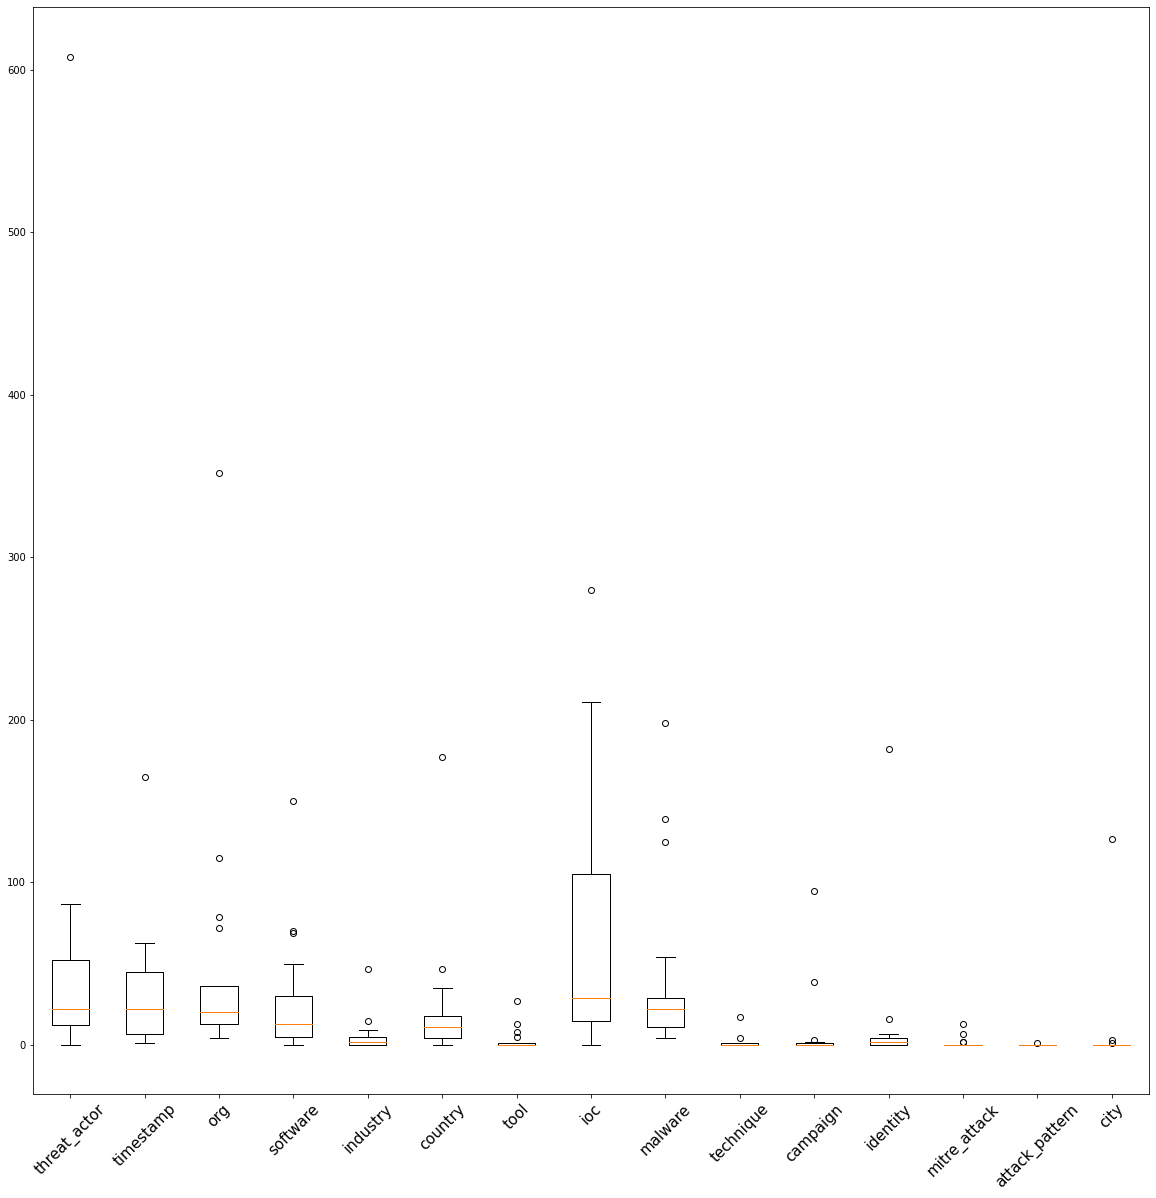

In [108]:
# Pythopn 3.5+
plt.figure(figsize=(20,20))
labels, data = [*zip(*tag_occs.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable    
labels, data = tag_occs.keys(), tag_occs.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels, rotation=45, fontsize=15)
plt.show()

# Plot graph of common entities for 20200911_Talos_-_The_art_and_science_of_detecting_Cobalt_Strike, Mandiant_APT1_Report, Group-IB_Lazarus 

In [109]:
tags_small

['threat_actor',
 'software',
 'industry',
 'org',
 'timestamp',
 'malware',
 'country',
 'ioc',
 'identity',
 'campaign',
 'tool',
 'mitre_attack',
 'theat_actor',
 'attack_pattern',
 'technique',
 'city']

In [247]:
important_tags = ['threat_actor','industry','org','malware','country','technique','city']
important_tags = ['malware']

In [248]:
shoebox = {}
fileprefixes = {'Cobalt_Strike':'20200911_Talos_-_The_art_and_science_of_detecting_Cobalt_Strike',\
                'APT1':'Mandiant_APT1_Report', 'Lazarus':'Group-IB_Lazarus'}

vertices = []#list(fileprefixes)
for name in fileprefixes:
    prefix = fileprefixes[name]
    Doc_info = tagged_dataset[tagged_dataset['DocName']==prefix]
    Doc_info = Doc_info[Doc_info['text']!=name]
    shoebox[name] = Doc_info[Doc_info['intent'].isin(important_tags)]['text'].value_counts()[:5]
    vertices+=list(shoebox[name].index)
    
vertices = set(vertices)

In [249]:
list(fileprefixes)

['Cobalt_Strike', 'APT1', 'Lazarus']

In [250]:
from igraph import *

# Create graph
g = Graph(directed=True)

# Add vertices
g.add_vertices(len(list(fileprefixes))+len(vertices))

colors=['red','blue','green','magenta','yellow']

id_name_dict = {}

# Add ids and labels to vertices
for i, name in enumerate(list(fileprefixes)):
    g.vs[i]["id"]= i
    g.vs[i]["label"]= name
    g.vs[i]["color"]= 'red'
    g.vs[i]["size"]= 35
    g.vs[i]["label_size"] = 15
    id_name_dict[name] = i
    

for j, name in enumerate(vertices):
    g.vs[i+j+1]["id"]= i+j+1
    g.vs[i+j+1]["label"]= name[:10]
    g.vs[i+j+1]["color"]= 'white'
    g.vs[i+j+1]["label_size"] = 10
    
    
    g.vs[i+j+1]["size"]= 1

    
    id_name_dict[name] = i+j+1

   
edges = []
weights = []

for name_1 in list(fileprefixes):
    for name_2 in vertices:
        if name_1==name_2:
            continue
        if name_2 in shoebox[name_1].index:
            edges.append((id_name_dict[name_1],id_name_dict[name_2]))
            weights.append(shoebox[name_1].loc[name_2])
                
    

# Add edges
g.add_edges(edges)

# Add weights and edge labels
g.es['weight'] = weights
# g.es['label'] = weights

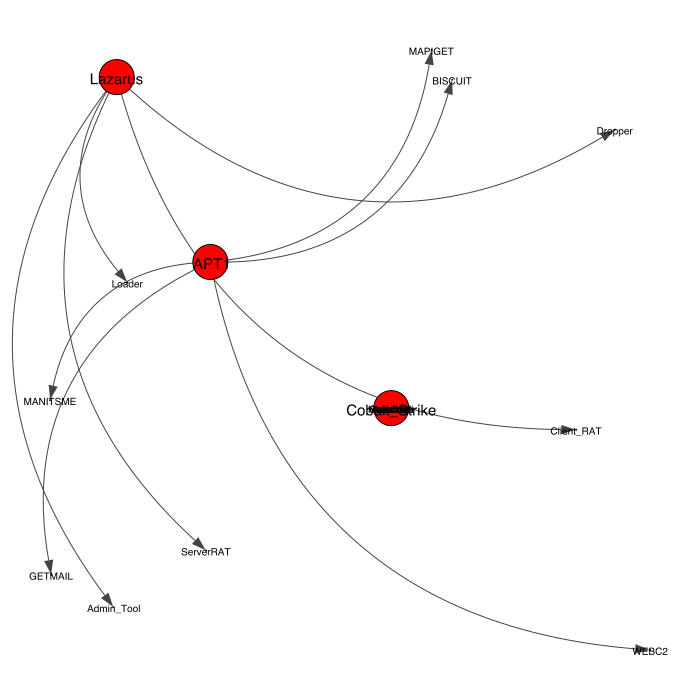

In [252]:
visual_style = {}

out_name = "graph.png"

# Set bbox and margin
visual_style["bbox"] = (700,700)
visual_style["margin"] = 50

# Set vertex colours
# visual_style["vertex_color"] = 'white'

# Set vertex size
# visual_style["vertex_size"] = 45

# Set vertex lable size
# visual_style["vertex_label_size"] = 22

# Don't curve the edges
visual_style["edge_curved"] = True

# Set the layout
my_layout = g.layout_lgl()
visual_style["layout"] = my_layout

# Plot the graph
plot(g, out_name, **visual_style)